# Setup and Installs

In [1]:
!pip install -qU langgraph "langchain[openai]" langchain-community langchain-text-splitters langchain-nvidia-ai-endpoints pypdf

In [2]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

In [4]:
_set_env("OPENAI_API_KEY")

In [5]:
_set_env("NVIDIA_API_KEY")

NVIDIA_API_KEY: ········


# All Imports

In [6]:
from langchain_community.document_loaders import PyPDFLoader

from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

from langchain.tools.retriever import create_retriever_tool

# Retrieval

## Load Documents into Vector Store
- Load the ArXivi papers
- Embed them using the NVIDIA NeMo Retriever
- Store the embeddings in vector store 

In [8]:
file_path = '/Users/ssankar/Documents/ai_bites/papers/group_norm.pdf'
loader = PyPDFLoader(file_path)

pages = []

async for page in loader.alazy_load():
    pages.append(page)

In [9]:
embedding = NVIDIAEmbeddings(model="nvidia/llama-3.2-nemoretriever-1b-vlm-embed-v1")

vector_store = InMemoryVectorStore.from_documents(pages, embedding)
retriever = vector_store.as_retriever()

/Users/ssankar/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_nvidia_ai_endpoints/_common.py:217: UserWarning: Found nvidia/llama-3.2-nemoretriever-1b-vlm-embed-v1 in available_models, but type is unknown and inference may fail.
  warnings.warn(


### Test if the vector store works

In [10]:
docs = vector_store.similarity_search("What is group normalization?", k=2)

for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 1: This paper presents Group Normalization (GN) as a sim-
ple alternative to BN. We notice that many classical features
like SIFT [39] and HOG [9] aregroup-wise features and in-
volve group-wise normalization. For example, a HOG vec-
tor is the outcome of several spatial cells where each cell is
repres

Page 0: Group Normalization
Yuxin Wu Kaiming He
Facebook AI Research (FAIR)
{yuxinwu,kaiminghe}@fb.com
Abstract
Batch Normalization (BN) is a milestone technique in the
development of deep learning, enabling various networks
to train. However, normalizing along the batch dimension
introduces problems — BN’s



## Build a Retrieval Tool for the Agent

In [11]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_papers",
    "Search and return information about Lilian Weng blog posts.",
)

# Build the Components of the Agent (for Agentic RAG)

## 1. Generator

In [12]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4.1", temperature=0)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}


### Test of it works 

In [13]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


## 2. Grade Documents

In [14]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    """
    You are a grader assessing the relevance of a retrieved document to a user question.
    
    User Question: {question}
    
    Retrieved Document:
    {context}
    
    Grading Criteria:
    - If the retrieved document contains keywords or phrases similar in meaning to those in the user question, grade it as "relevant".
    - If it does not contain similar keywords or meaning, grade it as "irrelevant".
    
    Output:
    - "yes" — if the document is relevant
    - "no" — if the document is irrelevant
    """
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    # print(f"question is: {question}")
    # print(f"context is: {context}")    

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    print(f"score is : {score}")

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"


### Test if it works 

In [15]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Group normalization has several advantages over batch normalization.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "advantages of group normalization"},
                    }
                ],
            },
            {"role": "tool", "content": "mehh", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

score is : no


'rewrite_question'

In [16]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the advantages of Group normalization over batch normalization?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "advantages of normalization"},
                    }
                ],
            },
            {"role": "tool", "content": "Group normalization is much faster than batch normalization.", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

score is : yes


'generate_answer'

## 3. Rewrite Questions

In [17]:
REWRITE_PROMPT = (
    """
    You are a question rewriter, improving the clarity and effectiveness of a user's original question.

    Original Question: {question}

    Rewrite Criteria:    
    Rewrite the question to make it clearer, more concise, and easier to understand, while preserving its original intent.
    
    If the question is ambiguous or vague, rephrase it to be more specific.
    
    Do not add new information or change the core meaning of the question.
    
    Output Format:
    
    Provide only the rewritten version of the question.
    """
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

### Test if it works

In [20]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "any inputs on group norm?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "types of group norm"},
                    }
                ],
            },
            {"role": "tool", "content": "mehh", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

Do you have any insights or feedback on group normalization?


## 4. Generate Answer

In [21]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved-context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### Test if it works 

In [22]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does the paper do?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "types of normalization"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Normalization can be categorized into group normalization, batch normalization, layer normalization, etc." 
                           "But this paper talks about completely getting rid of normalization layers!",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()


================================== Ai Message ==================================

The paper discusses the idea of completely removing normalization layers, such as group normalization, batch normalization, and layer normalization, from neural network architectures. Instead of relying on these normalization techniques, the paper explores alternative methods to achieve stable and effective training. The main focus is on demonstrating that normalization layers may not be strictly necessary for good performance.


# Build the Agent in LangGraph

In [23]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

graph = StateGraph(MessagesState)

# Define the nodes we will cycle between
graph.add_node(generate_query_or_respond)
graph.add_node("retrieve", ToolNode([retriever_tool]))
graph.add_node(rewrite_question)
graph.add_node(generate_answer)

graph.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
graph.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
graph.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
graph.add_edge("generate_answer", END)
graph.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
compiled_graph = graph.compile()


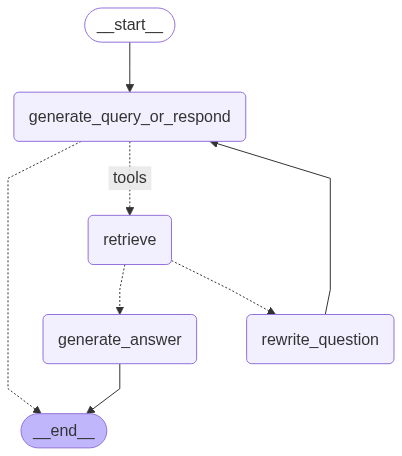

In [24]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [25]:
for chunk in compiled_graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Do you think AI is for good for humanity?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"Update from node: {node}")
        update["messages"][-1].pretty_print()
        print("\n\n")


Update from node: generate_query_or_respond
================================== Ai Message ==================================

That’s a great and complex question! The impact of AI on humanity is a topic of ongoing debate among experts, ethicists, and the general public. Here are some key points to consider:

**Potential Benefits:**
- **Healthcare:** AI can help diagnose diseases, personalize treatments, and accelerate drug discovery.
- **Education:** AI-powered tools can provide personalized learning experiences and make education more accessible.
- **Efficiency:** Automation of repetitive tasks can free up human time for more creative and meaningful work.
- **Safety:** AI can improve safety in areas like transportation (self-driving cars) and disaster response.

**Potential Risks:**
- **Job Displacement:** Automation may lead to job losses in certain sectors, requiring adaptation and retraining.
- **Bias and Fairness:** AI systems can perpetuate or even amplify existing biases if not 